In [1]:
#Important libraries
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
import sys
from matplotlib.pyplot import figure
from datetime import datetime
from datetime import timedelta
from scipy import signal
from scipy.interpolate import interp1d
import os
import math

Read Beach Profile datasets: Cross-shore beach profile data (Distance Vs Elevation)

In [4]:
# Sample Datasets for PMI calculation (yarra Beach, Gamay bay, Sydney, Australai)
yarra=pd.read_csv(r'data.csv')

In [5]:
yarra.head()

,Beach,Date,ProfileID,Distance,Elevation,Method
0,Yarra_Bay,12/05/2017,P4,0,3.571000,RTK
1,Yarra_Bay,12/05/2017,P4,1,3.381851,RTK
2,Yarra_Bay,12/05/2017,P4,2,3.181205,RTK
3,Yarra_Bay,12/05/2017,P4,3,3.011943,RTK
4,Yarra_Bay,12/05/2017,P4,4,2.846015,RTK


In [8]:
#Extract dates for the individual survey that will assist to identify the morphotpes individually
def check_dates(location):
    df_filtered = location[location['ProfileID']=="P4"]
    data = df_filtered[["Distance", "Elevation","Date" ]]
    dates=pd.to_datetime(data['Date'])
    dates = data.Date.unique()
    return dates
check_dates(yarra)

array(['12/05/2017'], dtype=object)

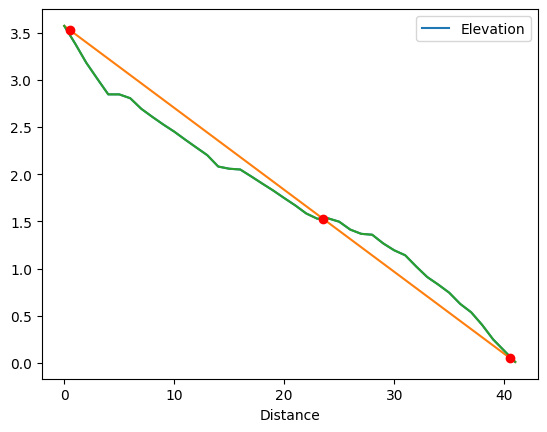

Slope of the Profile: 4.96
Concavity: -4.56 (min: -0.38 max: 0.0 ) Profile-percentage: 58.54 Mean Elevation: 2.38
Concavity: 2.74 (min: 0.03 max: 0.26 ) Profile-percentage: 41.46 Mean Elevation: 0.96


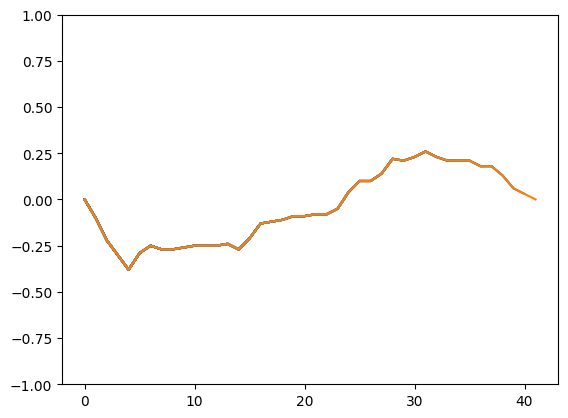

In [9]:
#Function to determine concavity, segmentwise profile percentage, slope and mean elevation
def extract_profile(dataframe,profile, date):
    group_profile=dataframe["ProfileID"].unique()
    group_dates=dataframe["ProfileID"].unique()
    #Extract Single profile
    single_profile=dataframe[dataframe['ProfileID']==profile]
    single_date = single_profile[single_profile['Date']==date]
    mask = (single_date['Elevation'] >= 0) & (single_date['Elevation'] <= 10)
    extent = single_date.loc[mask]
    extent.plot(x='Distance', y='Elevation')

    #interval vulaes to get the same number of y values for x values
    z=extent["Distance"].iloc[-1]+1
    xi=np.linspace(0.,1.,z)
    xm=np.flip(xi)
    #values fo calculation
    a=extent.iloc[:,3].iat[0]
    b=extent.iloc[:,3].iat[-1]
    ay=extent.iloc[:,4].iat[0]
    by=extent.iloc[:,4].iat[-1]

    #x distance on the imaginary line
    rff=[]
    for i in range(len(xm)):
        rf = xm[i]*a+(1-xm[i])*b
        rff.append(rf)

    #elevation on imaginary line from bottom
    xff=[]
    for i in range(len(xm)):
        xf = xm[i]*ay+(1-xm[i])*by
        xff.append(xf)

    #Convert dataframe column to numpy array to plot the imaginary line and inflection points
    xs = extent["Distance"].to_numpy()
    y1=xff
    y2=extent["Elevation"].to_numpy()
    plt.plot(xs,y1)
    plt.plot(xs,y2)

    #Inflection points and plot
    idx=np.argwhere(np.diff(np.sign(y1 - y2 )) != 0).reshape(-1) + 0
    idf=idx+1
    idf[0]=0
    for i in range(len(idx)):
        plt.plot((xs[idx[i]]+xs[idx[i]+1])/2.,(y1[idx[i]]+y1[idx[i]+1])/2., 'ro')
    plt.show()

    #Conversion of numpy array to list
    concavity=[]
    t = xm.tolist()
    for i in range(len(t)):
        a=extent.iloc[:,3].iat[0]
        b=extent.iloc[:,3].iat[-1]
        ay=extent.iloc[:,4].iat[0]
        by=extent.iloc[:,4].iat[-1]
        xl = t[i]*a+(1-t[i])*b
        ycu=np.interp(xl, extent["Distance"],extent["Elevation"])
        yl = t[i]*ay+(1-t[i])*by
        yc = (ycu-yl)
        yc=round(yc, 2)
        concavity.append(yc)
        plt.plot(concavity)
        plt.ylim([-1, 1])

    #Slope of the profile and segmentwise concavity, percentage, and Elevation

    #Slope of the profile
    y2 = np.max(extent['Elevation'])
    y1 = np.min(extent['Elevation'])
    x2 = np.max(extent['Distance'])
    x1 = np.min(extent['Distance'])
    gradient= ((y2-y1)/(x2-x1))
    gradient = abs(gradient)
    gradient_deg = np.rad2deg(math.atan(gradient))
    gradient = round(gradient, 2)
    gradient_deg = round(gradient_deg, 2)
    print("Slope of the Profile:",gradient_deg)

    #segmentwise concavity, percentage, and Elevation
    for h in range(len(idf)-1):
        #Concavity
        c=concavity[idf[h]:idf[h+1]]
        mx=max(c)
        mn=min(c)
        s_sum = math.fsum(c)
        s_sum=round(s_sum, 2)
        #Profile Percentage
        quotient = (idf[h+1]-idf[h]) /extent["Distance"].iloc[-1] 
        percent = quotient * 100
        percent=round(percent, 2)
        #segmentwise elevation
        elev_seg=extent['Elevation'].iloc[idf[h]:idf[h+1]]
        elev_mean_seg=elev_seg.mean()
        elev_mean_seg=round(elev_mean_seg, 2)

        print("Concavity:",s_sum,"(min:",mn,"max:",mx,")", "Profile-percentage:",percent, "Mean Elevation:",elev_mean_seg)

extract_profile(yarra,"P4","12/05/2017")

# Morphotypes Index Calculation

In [10]:
#Equation, Parameters and Factors

Sf1=-1
n=2
Sf2=1
Nf=1
#S=Ps*Ef (segment)
#Sg1=Ps1*Ef2 (segment 1)
#Sg2=Ps1*Ef2 (segment 2)
#Sg3=Ps1*Ef2 (segment 3)
Sg1=0.58*1
Sg2=0.42*1
Sg3=0
PMI=((Sf1*(Sg1+Sg2+Sg3))/(n*Sf2))*Nf


Elevation Factor (Ef) = 0, 1 (Elevation less than 0.1m=0, Elevation greater than 0.1m =1)

Normalization Factor (Nf) = 1, 1.90 (1.90 when a profile has three segments, a profile with 60-89% Convex portion, and a profile with 60-89% Concave portion), (1 for the remaining cases)

Sign Factor-1 (Sf1) =1, -1 (1 when the percentage of concave segments <40%), (-1 when the percentage of concave segments >40%)

Sign Factor-2 (Sf2) =1, -1 (-1 when only the first segment is Convex and the second segment is Concave in two segments profile), (1 for the remaining cases).

In [11]:
#Equation (PMI)
PMI=((Sf1*(Sg1+Sg2+Sg3))/(n*Sf2))*Nf
PMI

-0.5

In [12]:
def profile_morphotype(PMI):
    if PMI == -1.00:
        return "Concave"
    elif -0.950 <= PMI <= -0.570:
        return "Mostly Concave"
    elif PMI == -0.500:
        return "Concave-Convex"
    elif -0.295 <= PMI <= -0.205:
        return "Linear concave"
    elif PMI == 0.00:
        return "Linear"
    elif 0.055 <= PMI <= 0.200:
        return "Mostly Linear"
    elif 0.205 <= PMI <= 0.295:
        return "Linear Convex"
    elif PMI == 0.500:
        return "Convex-Concave"
    elif 0.570 <= PMI <= 0.950:
        return "Mostly Convex"
    elif PMI == 1.00:
        return "Convex"
    else:
        return "Combination"

In [13]:
profile_morphotype(PMI)

'Concave-Convex'